# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    5:'data/SeaFlow_SizeDist_regrid-15-5.nc',    # m=15, delta_v_inv=5
    8:'data/SeaFlow_SizeDist_regrid-25-8.nc',    # m=25, delta_v_inv=8
    10:'data/SeaFlow_SizeDist_regrid-35-10.nc',  # m=35, delta_v_inv=10
    19:'data/SeaFlow_SizeDist_regrid-60-19.nc',  # m=60, delta_v_inv=19
}

data_seaflow = {}
for k in datafiles:
    data_seaflow[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_seaflow[k][var] = nc.variables[var][:]

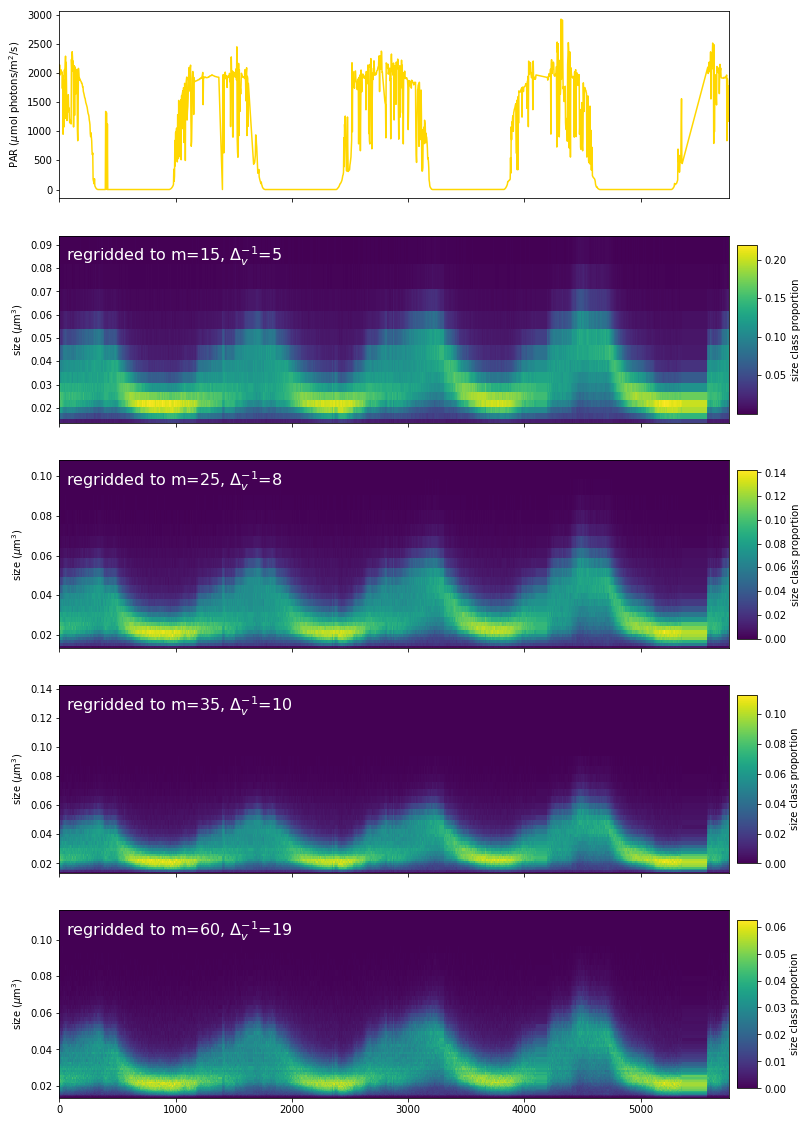

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

nrows = 1+len(datafiles)
fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

ax = axs[0]
ax.plot(data_seaflow[5]['time'], data_seaflow[5]['PAR'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

for ax,k in zip(axs[1:], data_seaflow):
    v_min = data_seaflow[k]['v_min']
    delta_v = 1.0/data_seaflow[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v) 
    pc = ax.pcolormesh(data_seaflow[k]['time'],v,data_seaflow[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, 'regridded to m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]}'.format(data=data_seaflow[k]), color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [3]:
# prepare data for Stan model

data = {}

for k in data_seaflow:
    if k < 10:
        dt = 20 # in units of minutes
    else:
        dt = 10 # in units of minutes

    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_seaflow[k][v]

    data[k]['obs'] = data_seaflow[k]['w_obs']
    data[k]['t_obs'] = data_seaflow[k]['time']
    data[k]['E'] = data_seaflow[k]['PAR']
    # use first measurements as initial conditions
    data[k]['w_ini'] = data_seaflow[k]['w_obs'][:,0]

    # limit the data

    limit_days = 2
    stride_t_obs = 20

    # remove very first observations
    ind_obs = data[k]['t_obs'] > 3
    data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
    data[k]['obs'] = data[k]['obs'][:,ind_obs]

    if limit_days > 0:
        limit_minutes = limit_days*1440

        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]

        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    if stride_t_obs > 0:
        data[k]['t_obs'] = data[k]['t_obs'][::stride_t_obs]
        data[k]['obs'] = data[k]['obs'][:,::stride_t_obs]

    data[k]['nt_obs'] = data[k]['obs'].shape[1]

    # finally, add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_seaflow[k]['time'], fp=data_seaflow[k]['PAR'])

In [4]:
import pystan

modelfiles = {
    'oldformulation':'stancode/matrixmodel_sigmoidaldelta.stan',
    'normparam':'stancode/matrixmodel_sigmoidaldelta_normparam.stan',
}

models = {name:pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False) for name in modelfiles}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL oldformulation NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL normparam NOW.


In [5]:
# run a bunch of experiments -- this may take a while

mcmc = {}
for name in models:
    mcmc[name] = {}
    for k in data:
        mcmc[name][k] = models[name].sampling(data=data[k], iter=2000)
        print('model: "{}", delta_v_inv={}'.format(name, k))
        print('\n'.join(x for x in mcmc[name][k].__str__().split('\n') if 'mod_obspos' not in x))

model: "oldformulation", delta_v_inv=5
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.35    0.03   0.98   2.88   3.66   4.18   4.88   6.76   1068    1.0
gamma_max          15.12    0.16   4.52  10.84  12.31  13.41   16.3  28.13    846    1.0
sig_offset          0.04  8.9e-5 2.9e-3   0.03   0.03   0.04   0.04   0.04   1049    1.0
sig_steepness     212.29    1.94   64.9 115.42 165.26 201.77 246.91 365.51   1115    1.0
E_star            766.07   28.37 807.23  40.01 167.95 392.37 1196.6 2874.3    810    1.0
sigma               0.11  1.4e-4 6.3e-3    0.1   0.11   0.11   0.12   0.13   1876    1.0
lp__              -135.4    0.04   1.69 -139.5 -136.3 -135.1 -134.2 -133.1   1463    1.0

Samples were drawn using NUTS at Tue Feb  4 16:23:54 2020.
For each parameter, n_eff is 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "oldformulation", delta_v_inv=8
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.22    0.03    0.9   2.87   3.59   4.09   4.68   6.39   1004    1.0
gamma_max          23.07    0.22    5.9  17.17  19.49  21.02  23.96  40.28    699   1.01
sig_offset          0.04  9.1e-5 2.9e-3   0.03   0.03   0.04   0.04   0.04   1047    1.0
sig_steepness     198.91    1.61  58.83 107.12 156.79 190.16 231.91 334.47   1338    1.0
E_star            602.68   26.78 698.36  18.88 119.57  275.8 882.77 2487.4    680   1.01
sigma               0.12  1.5e-4 6.3e-3    0.1   0.11   0.12   0.12   0.13   1894    1.0
lp__              -139.8    0.05   1.75 -143.9 -140.7 -139.5 -138.5 -137.4   1291    1.0

Samples were drawn using NUTS at Tue Feb  4 16:27:36 2020.
For each parameter, n_eff is 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "oldformulation", delta_v_inv=10
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.19    0.03   0.94   2.77   3.52   4.03   4.71   6.46    894    1.0
gamma_max          26.81    0.25   6.28  20.63  23.48  25.08   27.3  47.68    645    1.0
sig_offset          0.04  1.1e-4 3.2e-3   0.03   0.03   0.04   0.04   0.04    856    1.0
sig_steepness     189.56    1.87  61.61 102.05 143.78 179.21 224.17 335.91   1090    1.0
E_star            471.21   25.07 630.33  18.99 103.82 203.28 523.63 2454.1    632    1.0
sigma               0.12  1.5e-4 6.4e-3   0.11   0.11   0.12   0.12   0.13   1951    1.0
lp__              -142.9    0.05   1.81 -147.3 -143.9 -142.6 -141.6 -140.3   1383    1.0

Samples were drawn using NUTS at Tue Feb  4 16:37:51 2020.
For each parameter, n_eff is

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "oldformulation", delta_v_inv=19
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.89    0.03   0.85   2.54   3.32   3.79   4.32   5.93    877    1.0
gamma_max          49.02    0.51   9.54  38.84  44.09  47.13  50.39  81.21    352    1.0
sig_offset          0.04  9.3e-5 2.9e-3   0.03   0.03   0.04   0.04   0.04    946    1.0
sig_steepness     195.51     1.8  61.96 103.54 151.41  187.7 228.46 343.88   1184    1.0
E_star            331.38   29.83 538.29   9.05  62.56  130.5 279.62 2111.3    326    1.0
sigma               0.12  1.3e-4 6.5e-3   0.11   0.12   0.12   0.13   0.14   2373    1.0
lp__              -147.4    0.07   1.92 -152.0 -148.4 -147.1 -146.0 -144.7    861    1.0

Samples were drawn using NUTS at Tue Feb  4 16:54:30 2020.
For each parameter, n_eff is

model: "normparam", delta_v_inv=5
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.38    0.03   0.98   2.87   3.69   4.23   4.92   6.79    982    1.0
gamma_max            2.2    0.02   0.62   1.59   1.82   1.98   2.33   3.96    865    1.0
sig_offset          0.04  8.9e-5 2.8e-3   0.03   0.03   0.04   0.04   0.04   1010    1.0
sig_steepness     210.11    2.03  64.82 116.59  162.2 200.13 244.19 368.14   1016    1.0
E_star            706.29   26.98  758.1  39.01 155.94  356.5 1073.2 2709.8    789    1.0
sigma               0.11  1.4e-4 6.1e-3    0.1   0.11   0.11   0.12   0.13   1846    1.0
lp__              -137.3    0.05   1.72 -141.6 -138.3 -137.0 -136.0 -134.9   1410    1.0

Samples were drawn using NUTS at Tue Feb  4 16:57:18 2020.
For each parameter, n_eff is a crude me

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "normparam", delta_v_inv=8
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.22    0.03   0.91   2.86   3.58   4.06   4.69   6.42    927    1.0
gamma_max           2.12    0.02   0.61   1.54   1.76    1.9   2.23   3.92    634    1.0
sig_offset          0.04  9.5e-5 2.9e-3   0.03   0.03   0.04   0.04   0.04    942    1.0
sig_steepness     199.26    1.68  59.19 107.42  156.4 191.34 233.23  331.8   1248    1.0
E_star            635.82   31.56 761.97  22.05 121.46 272.29 941.78 2682.3    583    1.0
sigma               0.12  1.5e-4 6.5e-3   0.11   0.11   0.12   0.12   0.13   1954    1.0
lp__              -142.3    0.05   1.83 -146.7 -143.2 -141.9 -141.0 -139.8   1137    1.0

Samples were drawn using NUTS at Tue Feb  4 17:01:02 2020.
For each parameter, n_eff is a crude me

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "normparam", delta_v_inv=10
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           4.22    0.03    1.0   2.74   3.52   4.07   4.73    6.6    851   1.01
gamma_max           1.94    0.02    0.5   1.47   1.69    1.8   1.96   3.46    639    1.0
sig_offset          0.04  1.2e-4 3.3e-3   0.03   0.03   0.04   0.04   0.05    816   1.01
sig_steepness     188.44    1.92  62.38 101.84 143.83 177.26 219.13 347.16   1050    1.0
E_star            479.89   26.61 661.78  21.49 105.13 208.12 500.73 2484.8    618    1.0
sigma               0.12  1.5e-4 6.5e-3   0.11   0.11   0.12   0.12   0.13   1977    1.0
lp__              -145.5    0.06   1.87 -150.0 -146.5 -145.2 -144.1 -142.9   1126    1.0

Samples were drawn using NUTS at Tue Feb  4 17:12:21 2020.
For each parameter, n_eff is a crude m

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "normparam", delta_v_inv=19
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.91    0.03   0.85   2.56   3.32   3.81   4.36   5.94    868   1.01
gamma_max           1.82    0.02    0.4   1.44   1.63   1.74   1.86   3.04    360   1.01
sig_offset          0.04 10.0e-5 2.9e-3   0.03   0.03   0.04   0.04   0.04    829   1.01
sig_steepness     193.36    2.07   62.1 102.73 149.81 182.88 226.09 340.36    902   1.01
E_star             330.6    31.1 569.79  10.37  64.51  133.5 282.93 2259.0    336   1.01
sigma               0.12  1.4e-4 6.6e-3   0.11   0.12   0.12   0.13   0.14   2076    1.0
lp__              -150.7    0.07   1.95 -155.3 -151.8 -150.4 -149.2 -147.9    790    1.0

Samples were drawn using NUTS at Tue Feb  4 17:27:29 2020.
For each parameter, n_eff is a crude m

## Plot the results

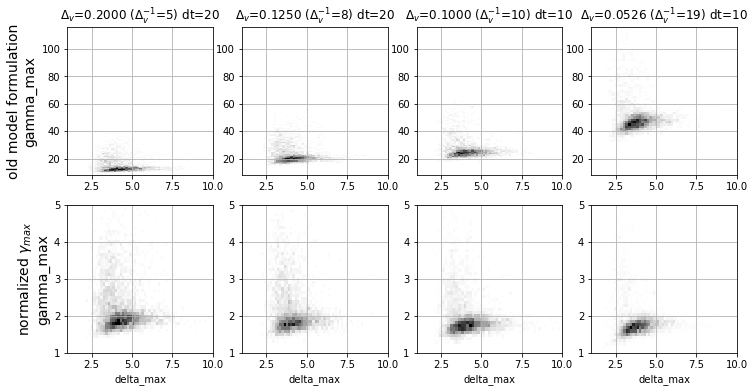

In [6]:
xname = 'delta_max'
yname = 'gamma_max'

desc = {'oldformulation':'old model formulation', 'normparam':'normalized $\gamma_{max}$'}

ncols = len(data)
nrows = len(models)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12/ncols*nrows))

for irow,name in enumerate(models):
    xlim = np.array((1000,-1))
    ylim = np.array((1000,-1))
    for icol,k in enumerate(data):
        ax = axs[irow,icol]
        ax.hist2d(mcmc[name][k][xname],mcmc[name][k][yname],bins=50,cmap=mpl.cm.gray_r)
        ax.grid(True)
        
        cxlim = ax.get_xlim()
        cylim = ax.get_ylim()
        
        xlim[0] = min(xlim[0], cxlim[0])
        xlim[1] = max(xlim[1], cxlim[1])
        ylim[0] = min(ylim[0], cylim[0])
        ylim[1] = max(ylim[1], cylim[1])
        
        if icol == 0:
            ax.set_ylabel(desc[name]+'\n'+yname, size=14)
        if irow == 0:
            ax.set_title('$\Delta_v$={:.4f} ($\Delta_v^{{-1}}$={:.0f}) dt={:d}'.format(1/data[k]['delta_v_inv'],
                                                                               data[k]['delta_v_inv'],
                                                                               data[k]['dt']))
    for ax in axs[irow,:]:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
for ax in axs[-1,:]:
    ax.set_xlabel(xname)


In [7]:
sig_quantiles = {}

for name in models:
    sig_quantiles[name] = {}
    for k in data:
        m = data[k]['m']
        v_min = data_seaflow[k]['v_min']
        delta_v = 1.0/data_seaflow[k]['delta_v_inv']
        v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v) 
        num_samples = mcmc[name][k]['sig_offset'].shape[0]
        tmp = np.full((num_samples,m), fill_value=np.nan)
        for i in range(num_samples):
            tmp[i,:] = mcmc[name][k]['delta_max'][i]/(1.0+np.exp(-mcmc[name][k]['sig_steepness'][i]*(v-mcmc[name][k]['sig_offset'][i])))

        sig_quantiles[name][k] = np.percentile(tmp, q=(5,25,50,75,95), axis=0)

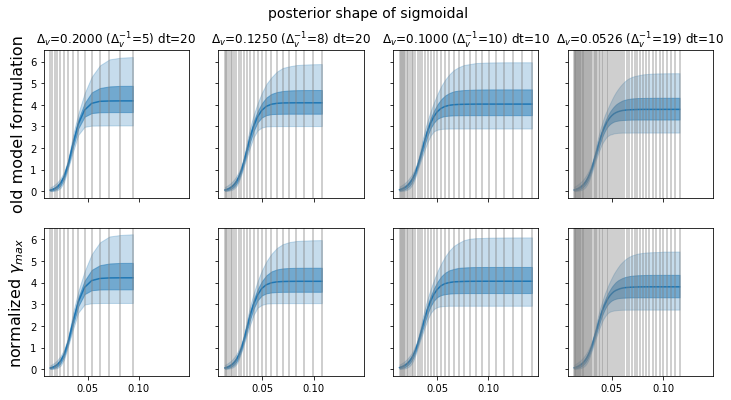

In [8]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12,12/ncols*nrows))

for irow,name in enumerate(models):
    for icol,k in enumerate(data):
        v_min = data_seaflow[k]['v_min']
        delta_v = 1.0/data_seaflow[k]['delta_v_inv']
        v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v)
        
        ax = axs[irow,icol]
        ax.fill_between(x=v, y1=sig_quantiles[name][k][0,:], y2=sig_quantiles[name][k][-1,:], alpha=0.25, color='C0')
        ax.fill_between(x=v, y1=sig_quantiles[name][k][1,:], y2=sig_quantiles[name][k][-2,:], alpha=0.5, color='C0')
        ax.plot(v, sig_quantiles[name][k][2,:], color='C0')
        
        if icol == 0:
            ax.set_ylabel(desc[name], size=16)
        if irow == 0:
            ax.set_title('$\Delta_v$={:.4f} ($\Delta_v^{{-1}}$={:.0f}) dt={:d}'.format(1/data[k]['delta_v_inv'],
                                                                               data[k]['delta_v_inv'],
                                                                               data[k]['dt']))
        for vi in v:
            ax.axvline(vi, color='.5', alpha=0.5)
fig.suptitle('posterior shape of sigmoidal', size=14)
None

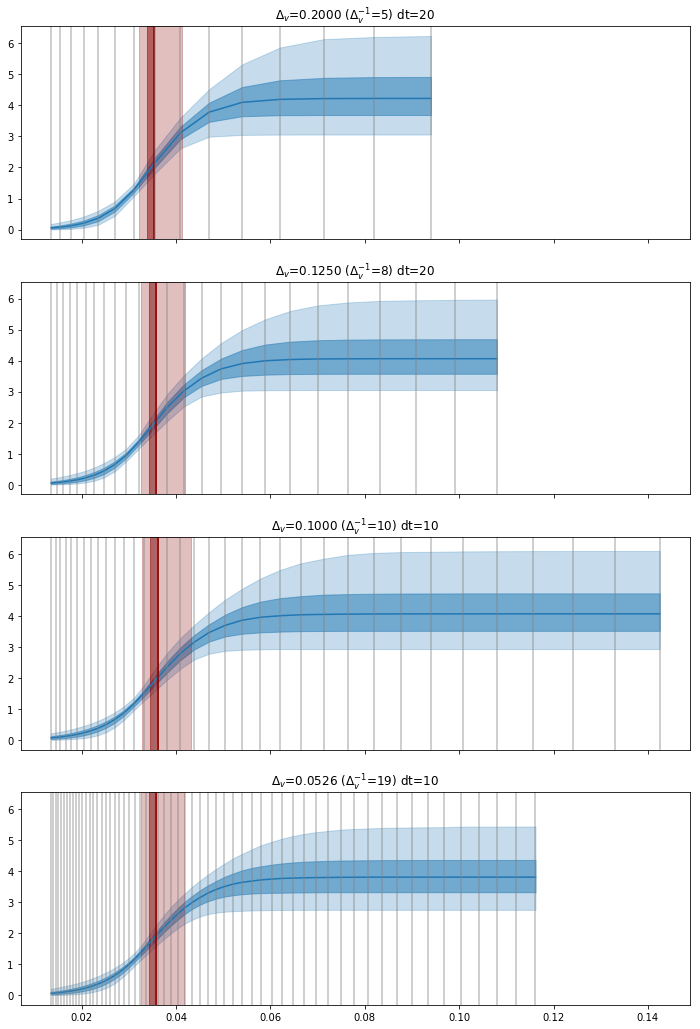

In [9]:
name = 'normparam'

fig, axs = plt.subplots(nrows=len(sig_quantiles[name]), sharex=True, sharey=True, figsize=(12,18))
for iax,k in enumerate(data):
    v_min = data_seaflow[k]['v_min']
    delta_v = 1.0/data_seaflow[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v)

    ax = axs[iax]
    ax.fill_between(x=v, y1=sig_quantiles[name][k][0,:], y2=sig_quantiles[name][k][-1,:], alpha=0.25, color='C0')
    ax.fill_between(x=v, y1=sig_quantiles[name][k][1,:], y2=sig_quantiles[name][k][-2,:], alpha=0.5, color='C0')
    ax.plot(v, sig_quantiles[name][k][2,:], color='C0')
    
    ax.set_title('$\Delta_v$={:.4f} ($\Delta_v^{{-1}}$={:.0f}) dt={:d}'.format(1/data[k]['delta_v_inv'],
                                                                               data[k]['delta_v_inv'],
                                                                               data[k]['dt']))
    qq = np.percentile(mcmc[name][k]['sig_offset'], q=(5,25,50,75,95))
    ax.axvspan(qq[0], qq[-1], color='darkred', alpha=0.25)
    ax.axvspan(qq[1], qq[2], color='darkred', alpha=0.5)
    ax.axvline(qq[2], color='darkred')
    for vi in v:
        ax.axvline(vi, color='.5', alpha=0.5)